In [15]:
import os, sys
import functools
import tempfile
import multiprocessing as mp
from typing import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from biotite import structure as struct
from biotite.structure.io.pdb import PDBFile

from foldingdiff import tmalign, nerf, utils, plotting
from foldingdiff import angles_and_coords as ac

PLOT_DIR = os.path.join(plotting.PLOT_DIR, "lever_effect")
assert os.path.isdir(PLOT_DIR)

In [3]:
average_test_error = pd.Series({
    'phi': 0.02716921642422676,
    'psi': -0.01977587677538395,
    'omega': 0.009203792549669743,
    'tau': -0.0013476869789883494,
    'CA:C:1N': 0.003867567051202059,
    'C:1N:1CA': -0.0034021877218037844
})
average_test_error

phi         0.027169
psi        -0.019776
omega       0.009204
tau        -0.001348
CA:C:1N     0.003868
C:1N:1CA   -0.003402
dtype: float64

In [12]:
def sweep_angles_for_tmscore(
    fname: str,
    deltas: Optional[pd.Series] = None,
    scalar: float = 0.2,
    disable_pbar: bool = True,
) -> np.ndarray:
    """
    For each angle in the structure, perturb it by scalar * deltas, reconstruct
    and measure TM score with respect to the original structure.
    """
    f = PDBFile.read(fname)
    assert f.get_model_count() == 1
    structure = f.get_structure(1)
    backbone = structure[struct.filter_backbone(structure)]
    angles = ac.canonical_distances_and_dihedrals(
        fname, distances=[], angles=ac.EXHAUSTIVE_ANGLES
    )

    if deltas is None:  # Set to std of each angle
        angles_0_2pi = angles.copy() % (2 * np.pi)
        deltas = angles_0_2pi.std(axis=0)

    # Function to take the angles back to [-pi, pi]
    recenter = lambda x: (x + np.pi) % (2 * np.pi) - np.pi

    # reconst = ac.create_new_chain_nerf(angles)
    retval = np.ones(shape=(len(angles), 3))
    with tempfile.NamedTemporaryFile() as tmp:
        # Write the set of angles into reference first
        reference = ac.create_new_chain_nerf(tmp.name, angles)
        # For each of the angles, perturb phi psi and omega
        for i in tqdm(range(len(angles)), disable=disable_pbar):
            for j in range(3):
                angles_perturbed = angles.copy()
                angles_perturbed.iloc[i, j] += scalar * deltas.iloc[j]
                angles_perturbed_centered = recenter(angles_perturbed)
                with tempfile.NamedTemporaryFile() as tmp2:
                    new_chain = ac.create_new_chain_nerf(tmp2.name, angles_perturbed_centered)
                    tm = tmalign.run_tmalign(new_chain, reference, fast=True)
                    retval[i, j] = tm
    retval = pd.DataFrame(retval, columns=deltas.index[:3])
    return retval
    
tm_deltas = sweep_angles_for_tmscore(
    "/home/wukevin/projects/protdiff/data/cath/dompdb/6nsjA00",
    disable_pbar=False,
)
tm_deltas

  0%|          | 0/182 [00:00<?, ?it/s]

,phi,psi,omega
0,1.00000,1.00000,1.00000
1,0.99999,0.99977,0.99999
2,0.99995,0.99922,0.99998
3,0.99979,0.99869,0.99998
4,0.99967,0.99826,0.99996
...,...,...,...
177,0.99947,0.99882,0.99998
178,0.99953,0.99909,0.99998
179,0.99966,0.99958,1.00000
180,0.99994,0.99997,1.00000


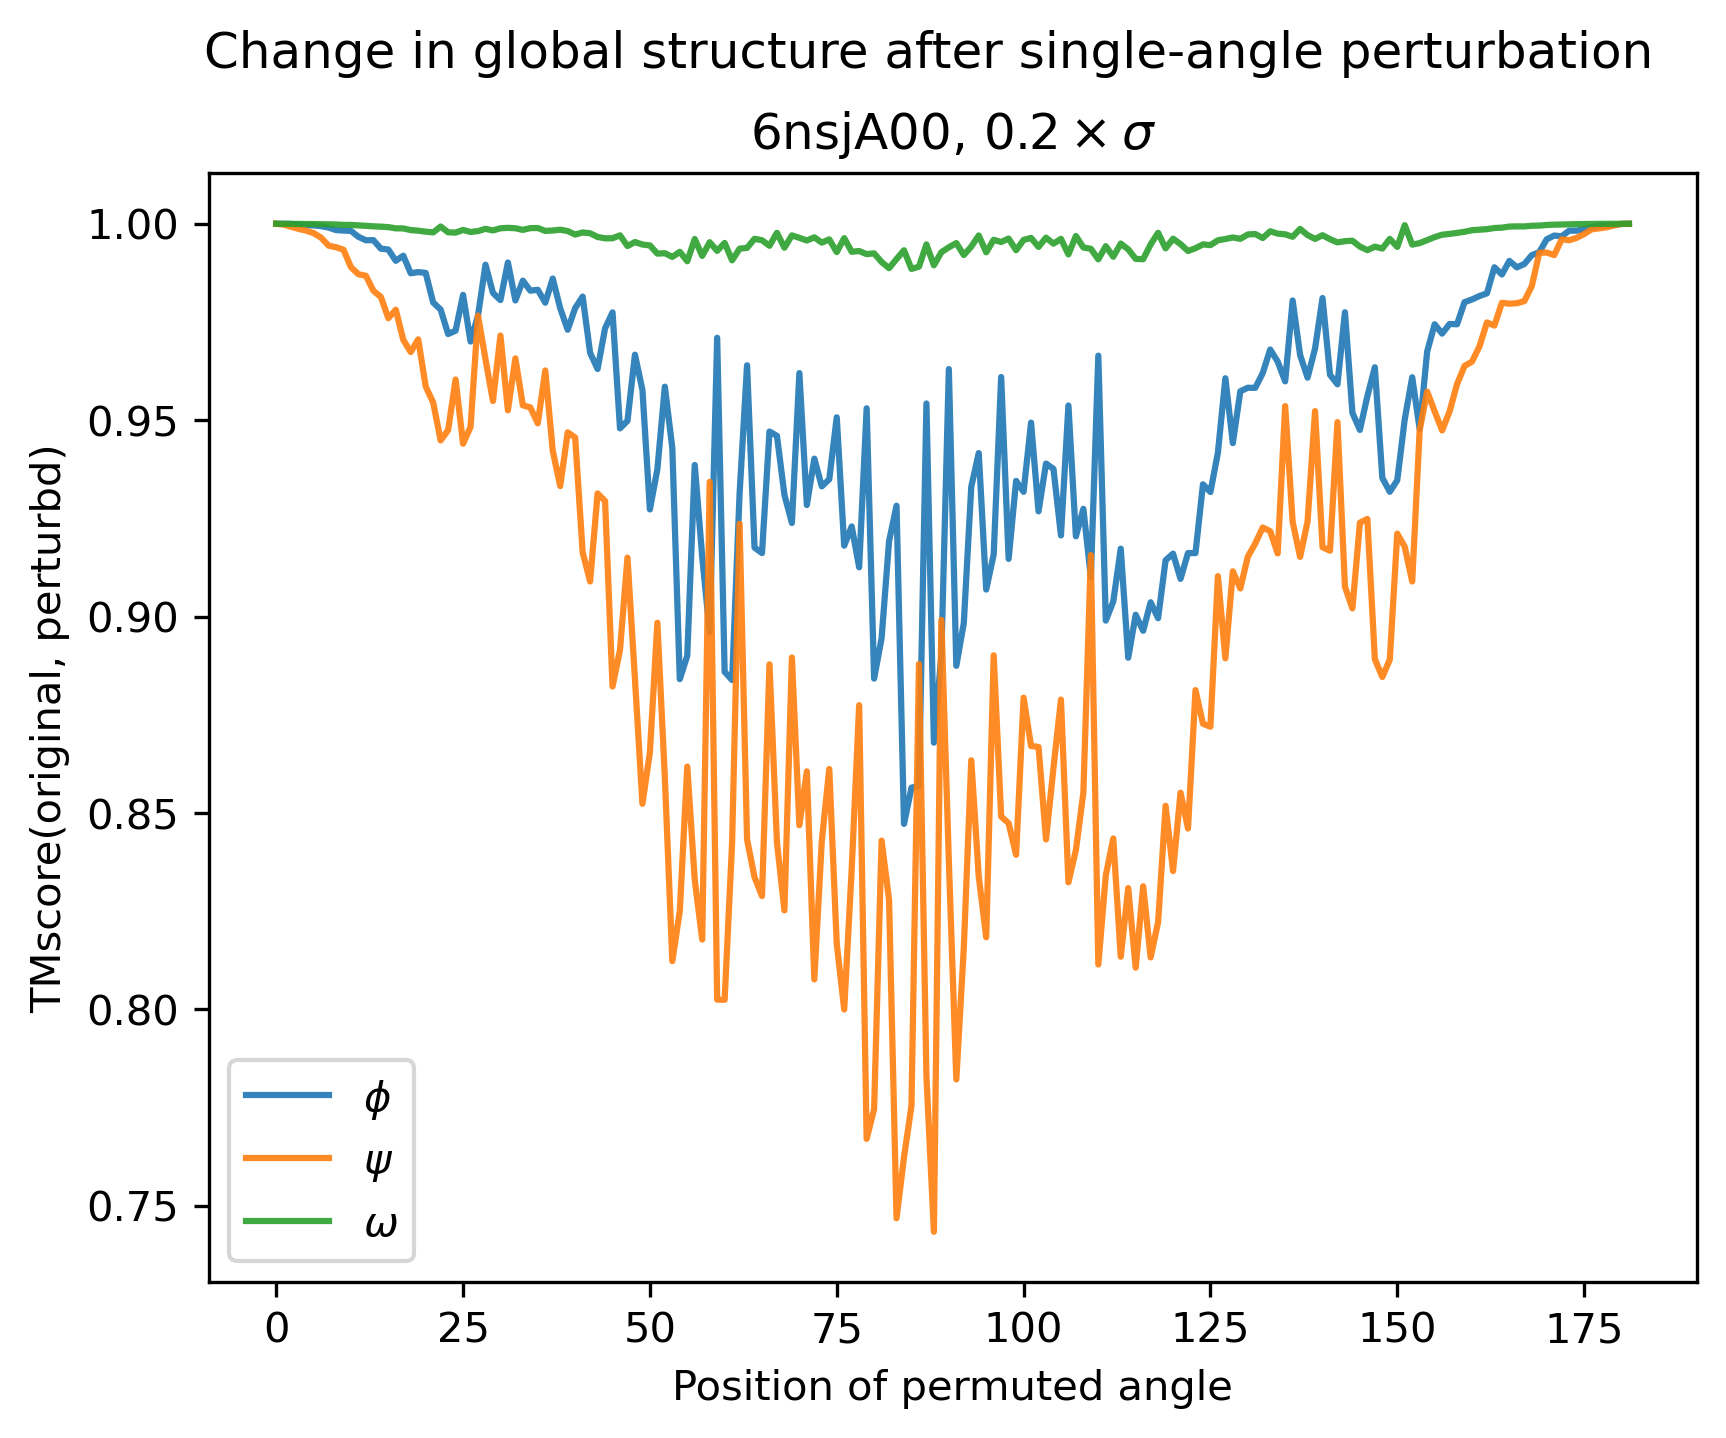

In [30]:
def plot_tm_deltas(
    tm_deltas: np.ndarray,
    fname: str = "",
    ax: Optional[plt.Axes] = None,
    disable_suptitle: bool = False,
    **kwargs
) -> plt.Figure:
    if ax is None:
        fig, ax = plt.subplots(dpi=300)
    else:
        fig = ax.get_figure()
    sns.lineplot(x=np.arange(len(tm_deltas)), y=tm_deltas[:, 0], label=r"$\phi$", alpha=0.9, ax=ax)
    sns.lineplot(x=np.arange(len(tm_deltas)), y=tm_deltas[:, 1], label=r"$\psi$", alpha=0.9, ax=ax)
    sns.lineplot(x=np.arange(len(tm_deltas)), y=tm_deltas[:, 2], label=r"$\omega$", alpha=0.9, ax=ax)
    ax.legend()

    if 'title' in kwargs:
        ax.set(
            xlabel="Position of permuted angle",
            ylabel="TMscore(original, perturbd)",
            **kwargs,
        )
        if not disable_suptitle:
            fig.suptitle("Change in global structure after single-angle perturbation")
    else:
        ax.set(
            xlabel="Position of permuted angle",
            ylabel="TMscore(original, perturbd)",
            title="Change in global structure after single-angle perturbation",
            **kwargs,
        )
    if fname:
        fig.savefig(fname, bbox_inches='tight')
    return fig

plot_tm_deltas(tm_deltas.values, title=r"6nsjA00, $0.2 \times \sigma$").show()

In [16]:
zero_two_pfunc = functools.partial(
    sweep_angles_for_tmscore,
    scalar=0.2,
)
cath_fnames = ["1xewY00", "2epdA00", "6nsjA00", "3l84A01"]
with mp.Pool(len(cath_fnames)) as pool:
    results = pool.map(
        zero_two_pfunc,
        [
            f"/home/wukevin/projects/protdiff/data/cath/dompdb/{cath_fname}"
            for cath_fname in ["1xewY00", "2epdA00", "6nsjA00", "3l84A01"]
        ]
    )
zero_two_deltas = dict(zip(cath_fnames, results))

In [21]:
zero_five_pfunc = functools.partial(
    sweep_angles_for_tmscore,
    scalar=0.5,
)
cath_fnames = ["1xewY00", "2epdA00", "6nsjA00", "3l84A01"]
with mp.Pool(len(cath_fnames)) as pool:
    results = pool.map(
        zero_five_pfunc,
        [
            f"/home/wukevin/projects/protdiff/data/cath/dompdb/{cath_fname}"
            for cath_fname in ["1xewY00", "2epdA00", "6nsjA00", "3l84A01"]
        ]
    )
zero_five_deltas = dict(zip(cath_fnames, results))

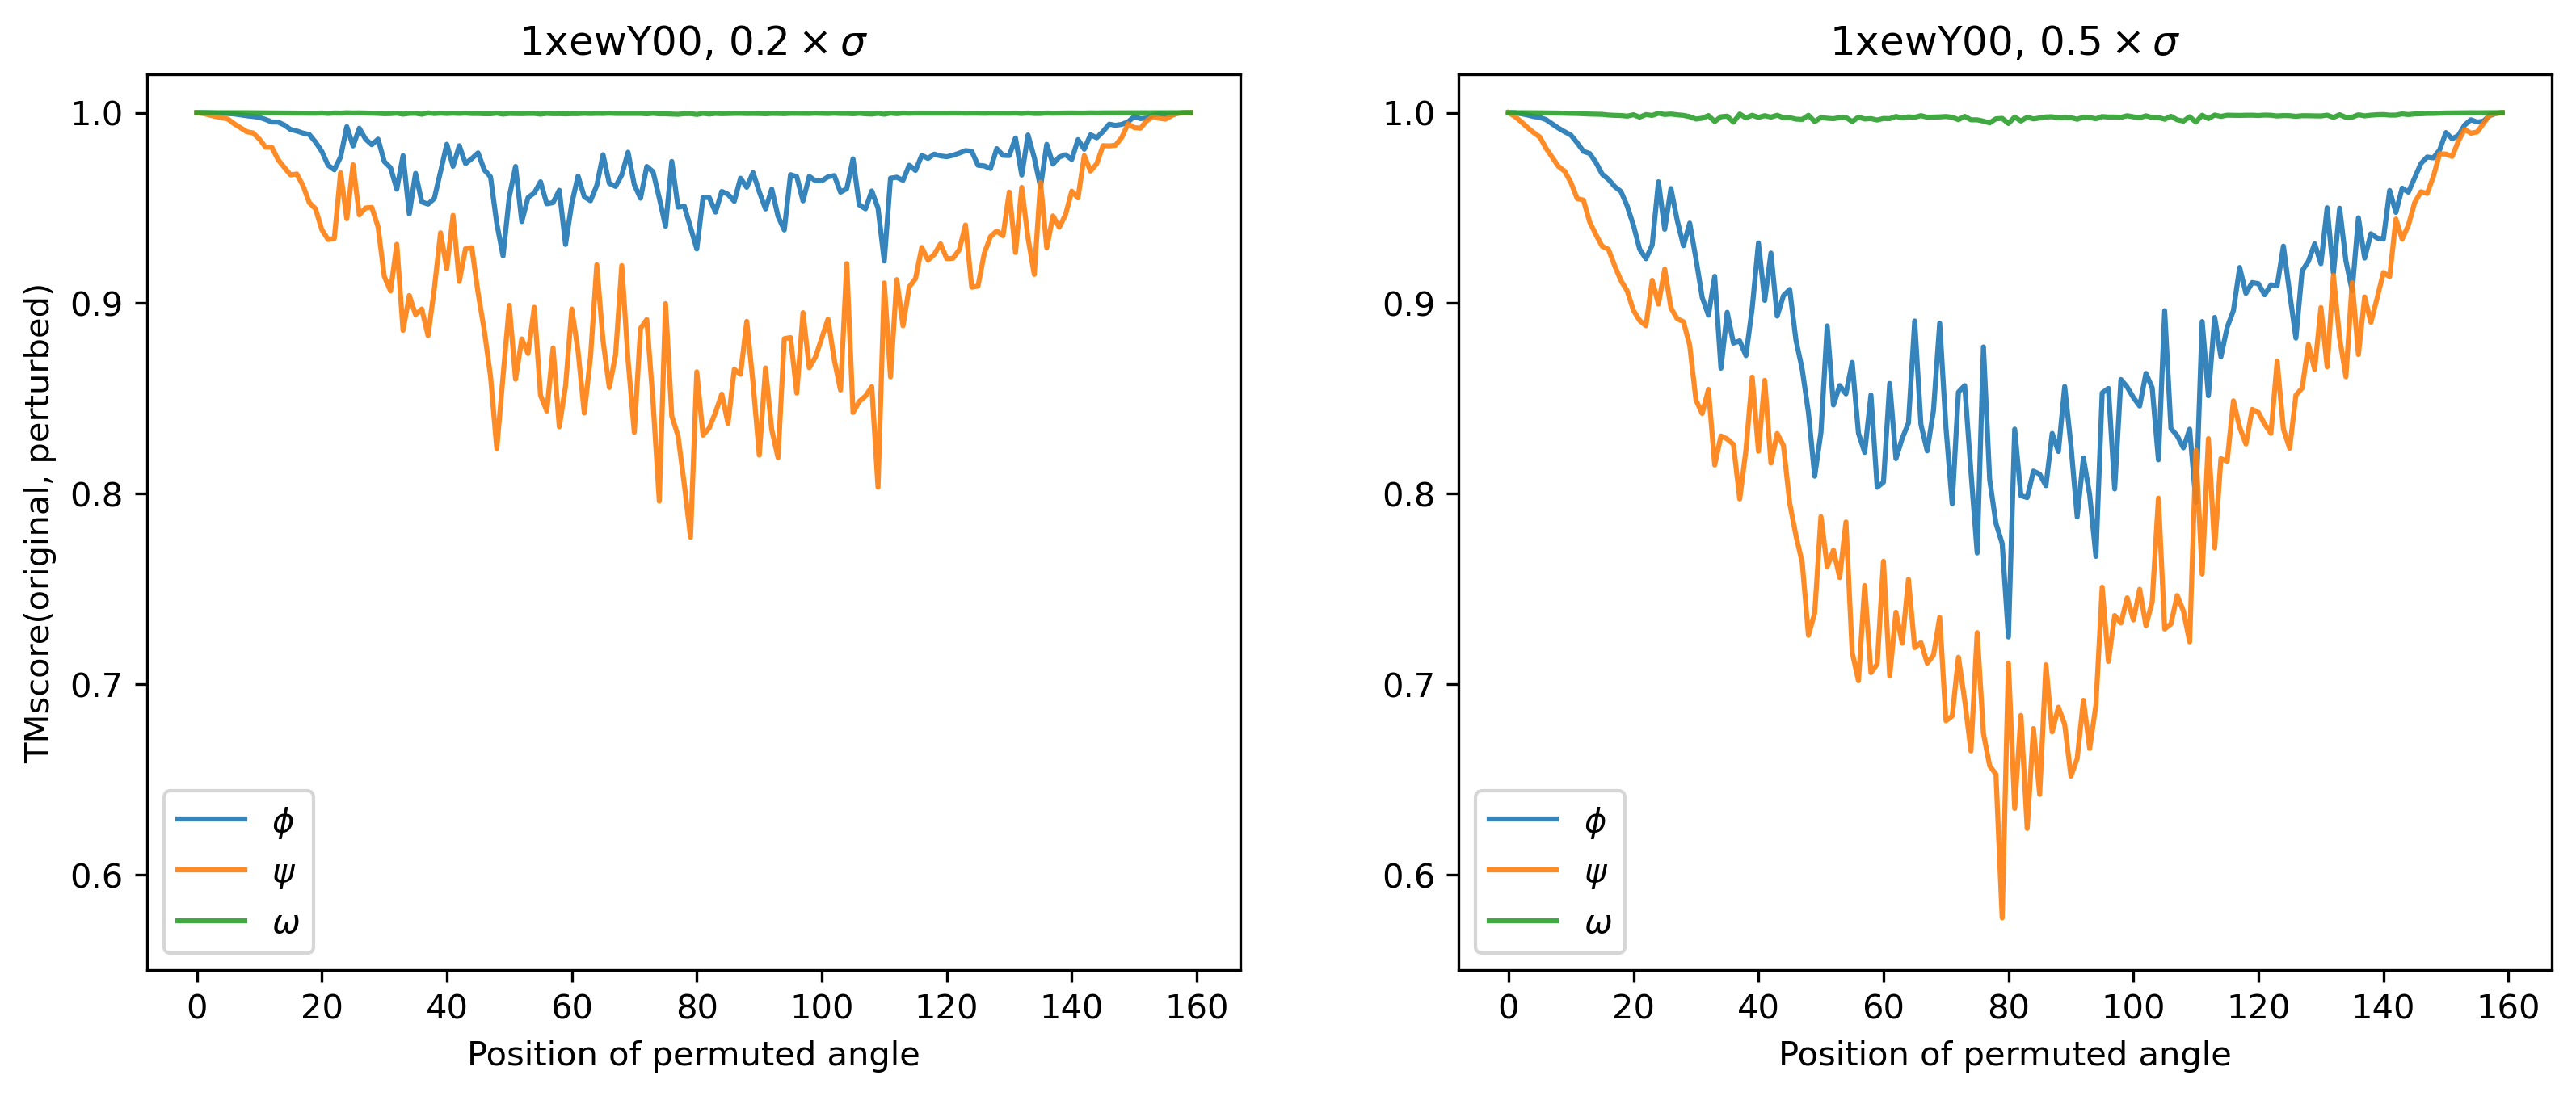

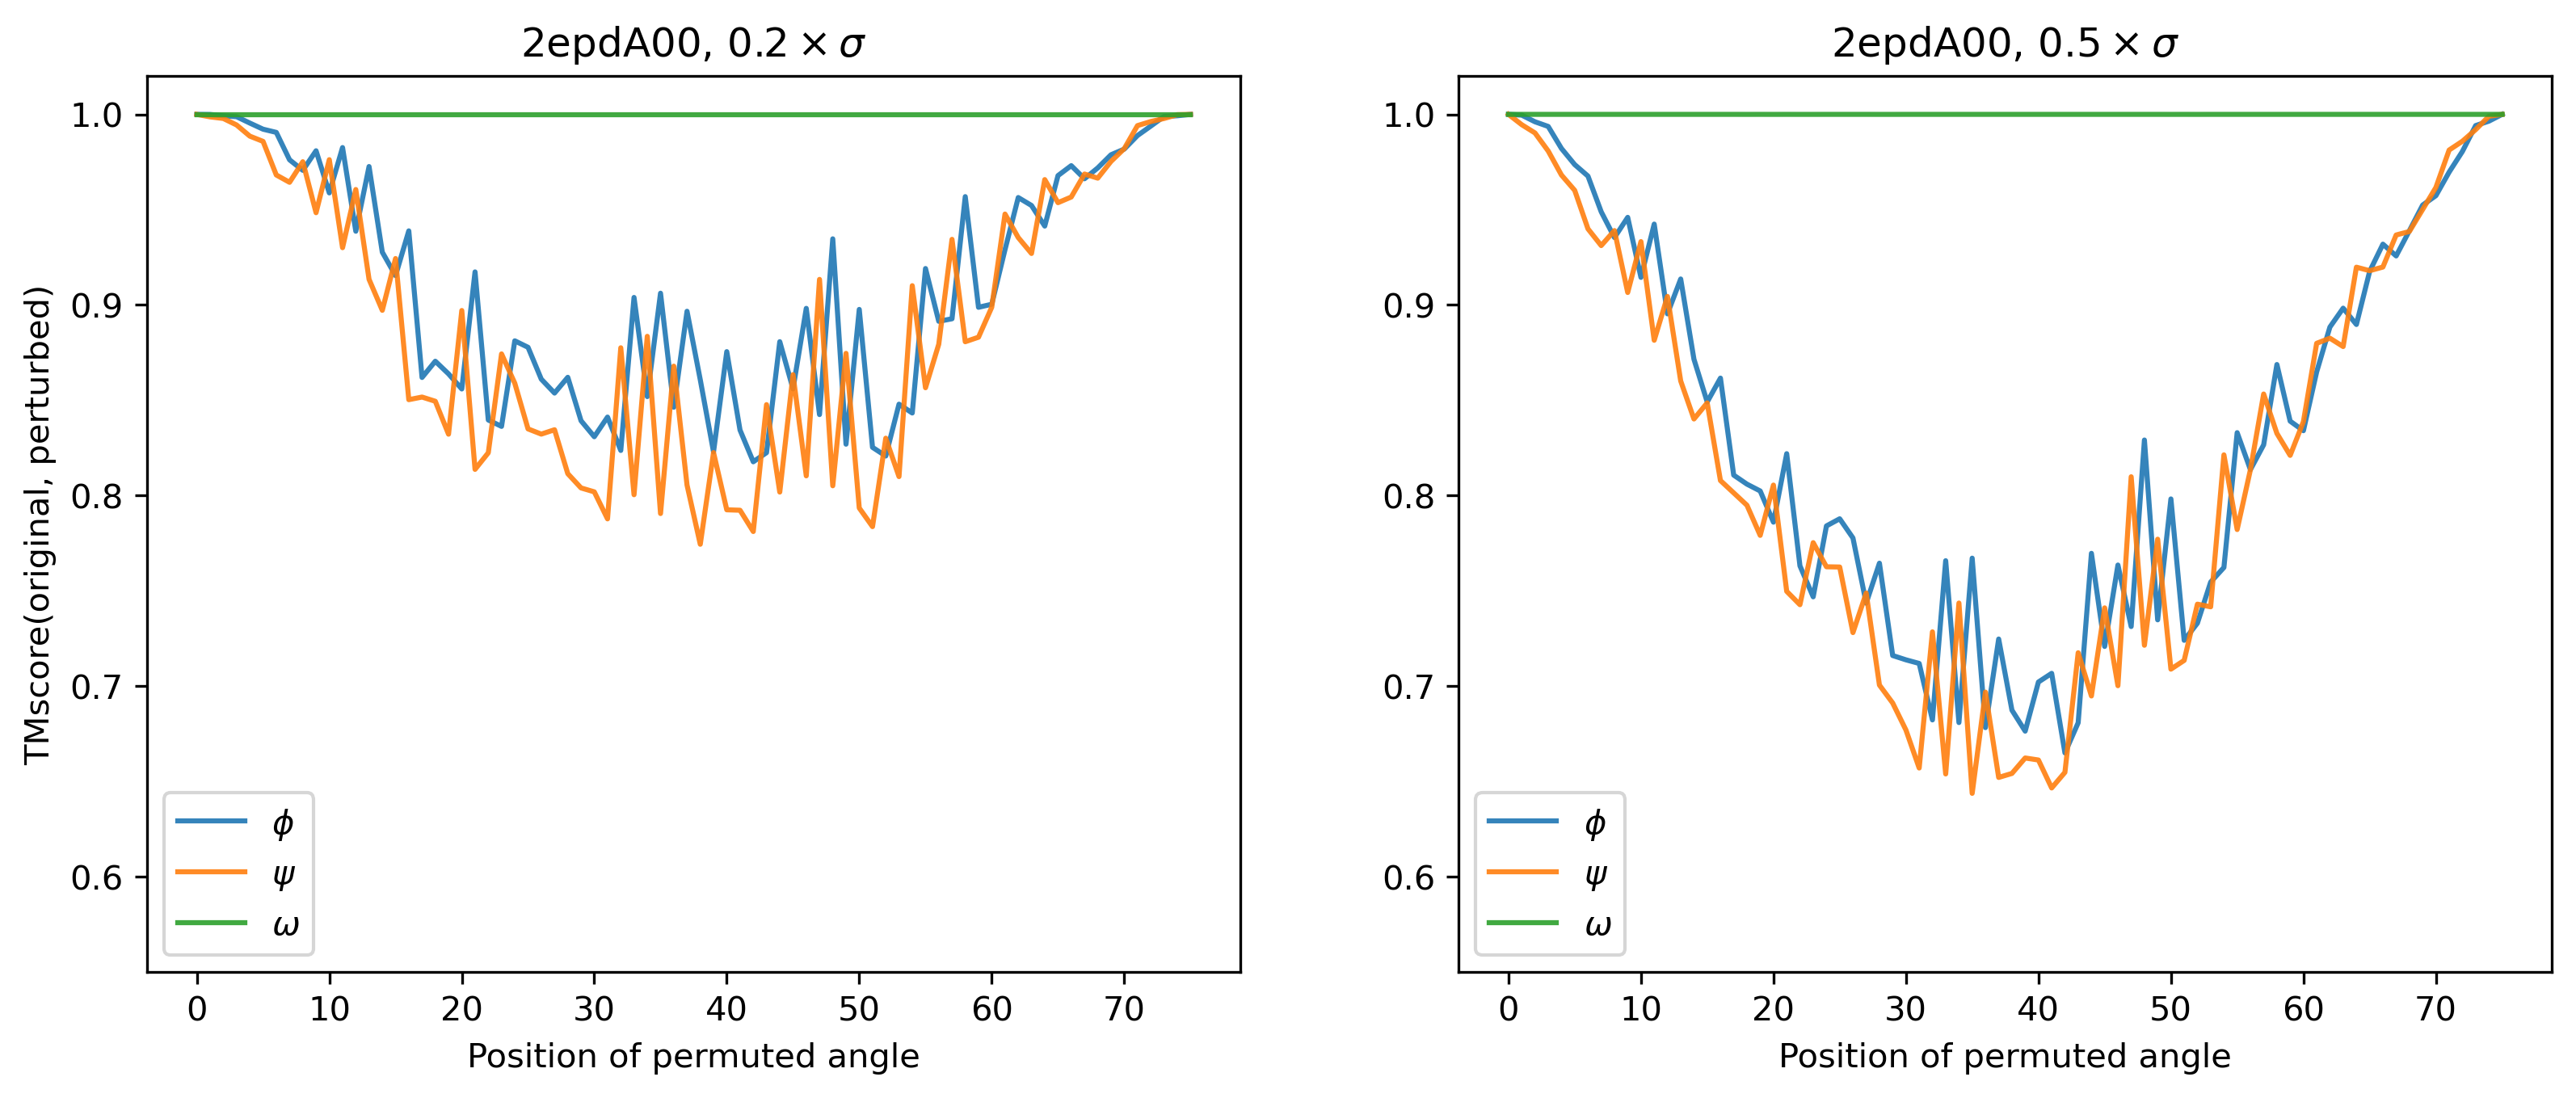

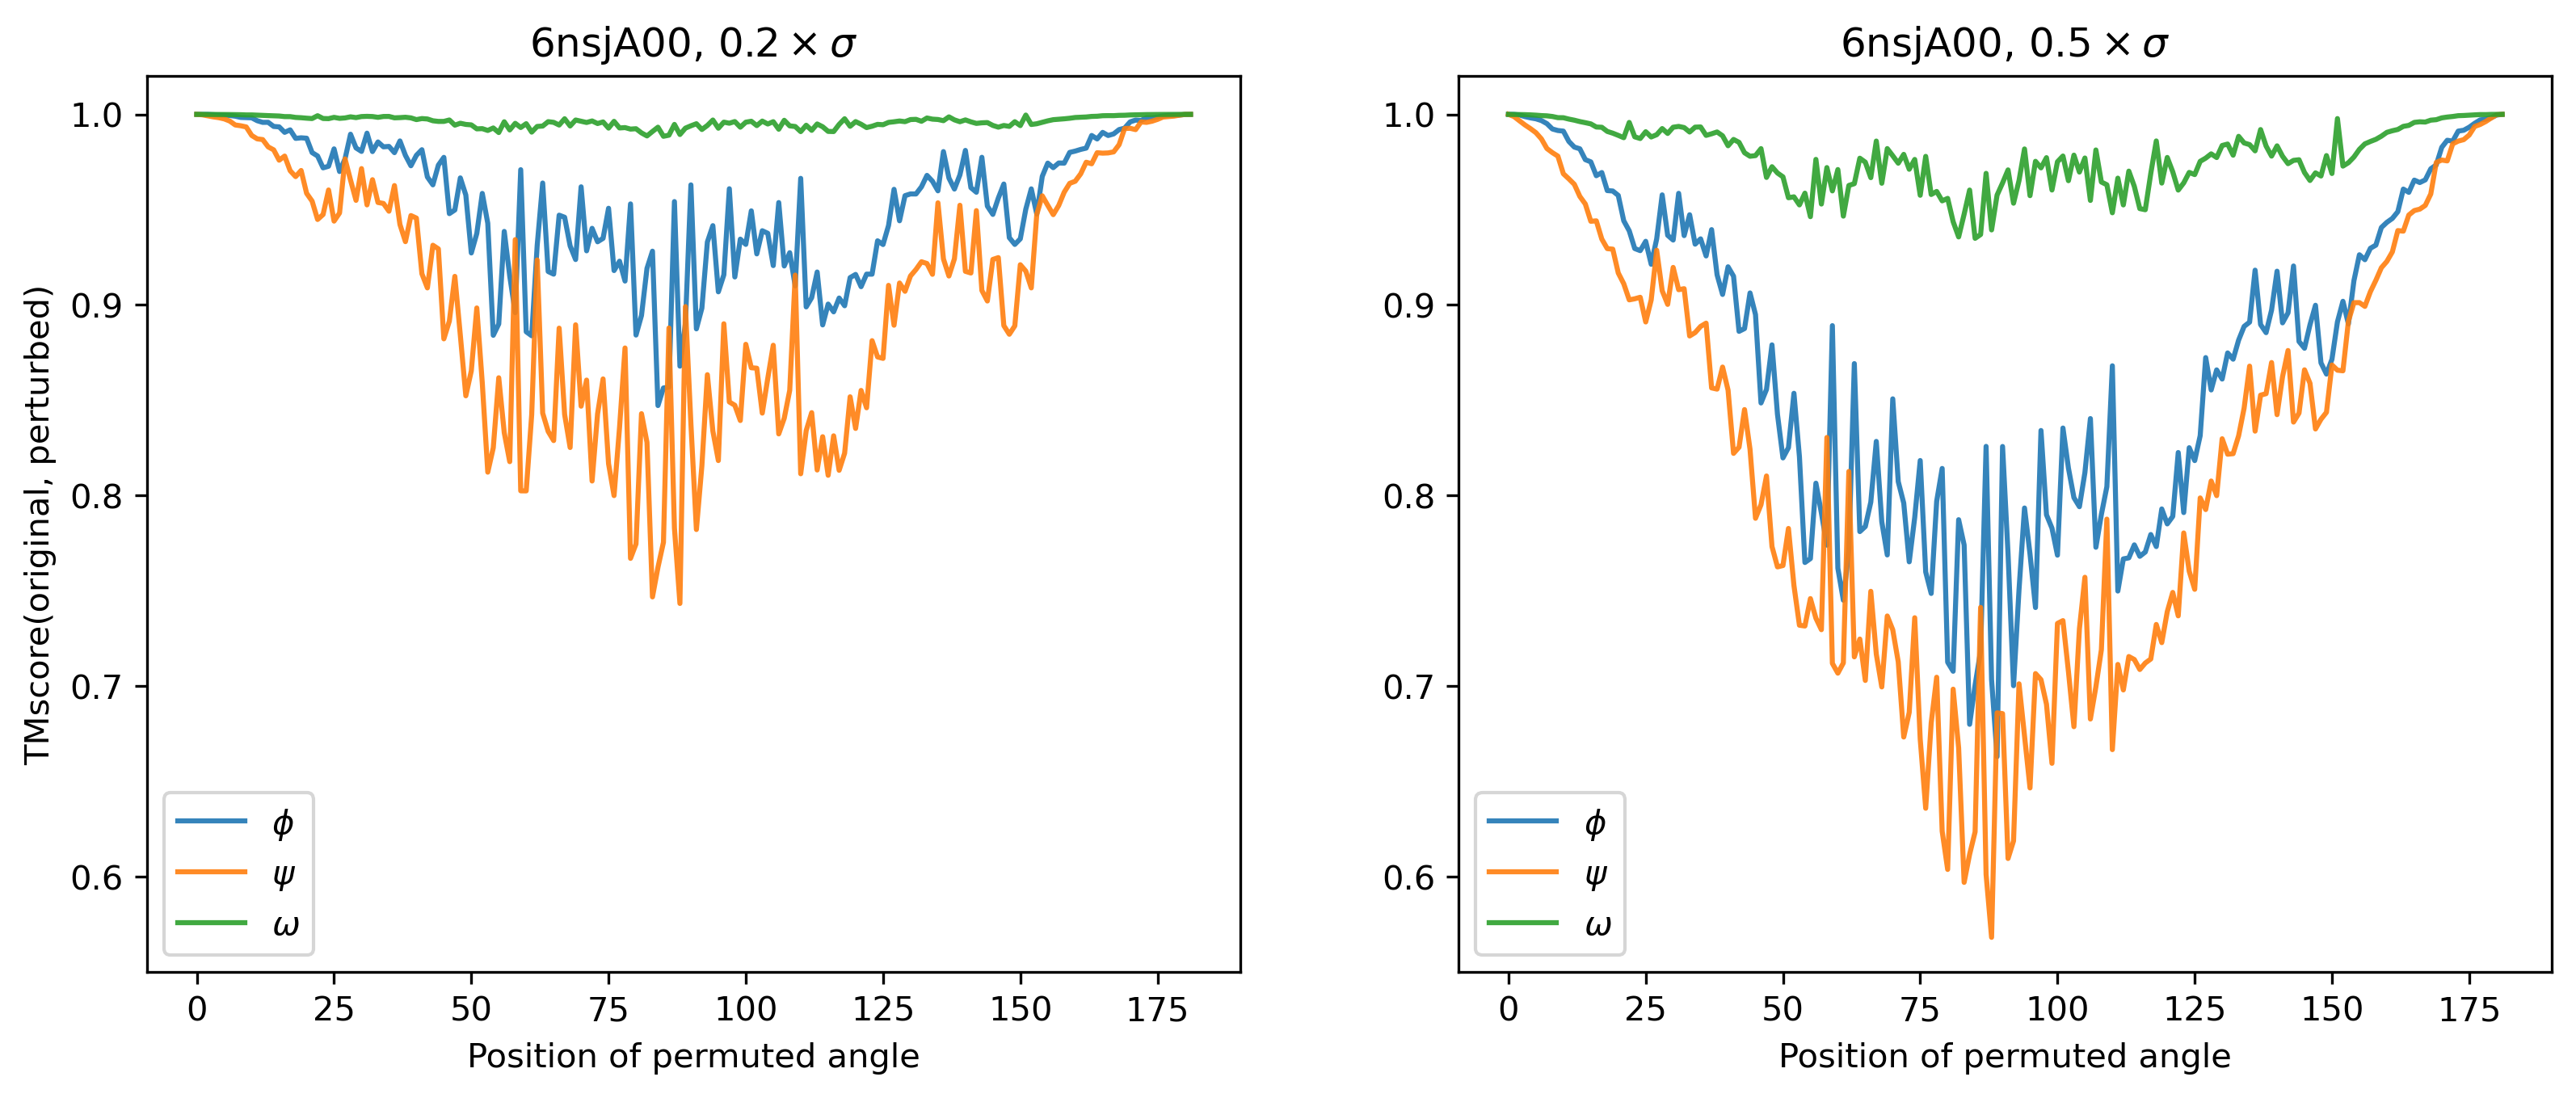

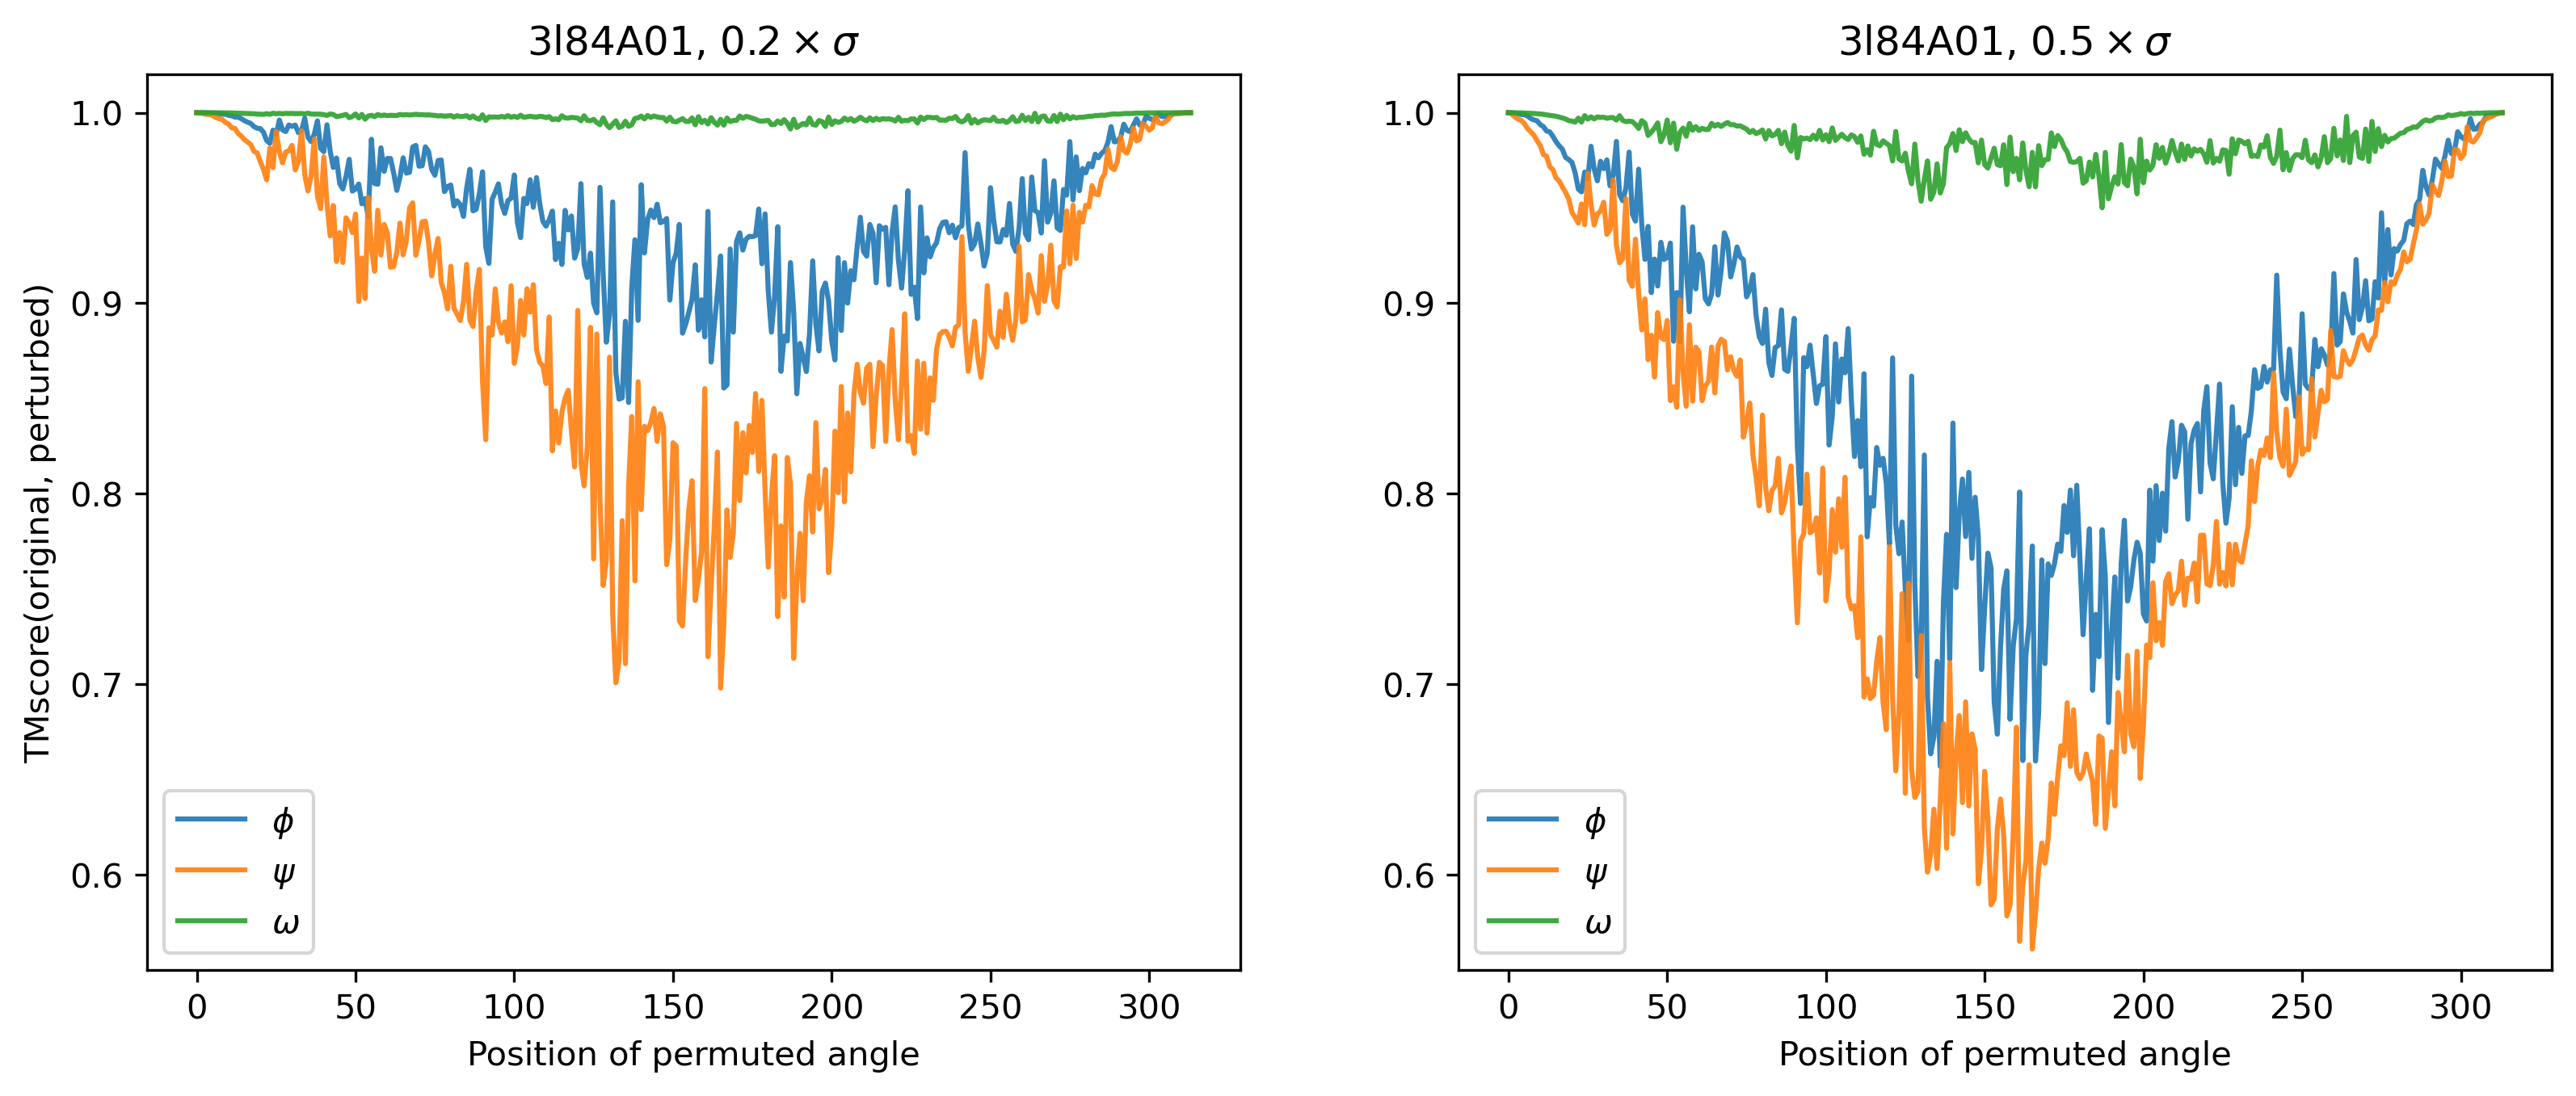

In [37]:
for cath_key in cath_fnames:
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, dpi=300, figsize=(6.4 * 2, 4.8))
    plot_tm_deltas(
        zero_two_deltas[cath_key].values,
        ax=ax1,
        title=cath_key + r", $0.2 \times \sigma$",
        disable_suptitle=True,
    )
    plot_tm_deltas(
        zero_five_deltas[cath_key].values,
        ax=ax2,
        title=cath_key + r", $0.5 \times \sigma$",
        disable_suptitle=True,
    )
    for ax in (ax1, ax2):
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.set(
            xlabel="Position of permuted angle",
            ylabel="TMscore(original, perturbed)",
            ylim=(0.55, 1.02),
        )
    fig.savefig(os.path.join(PLOT_DIR, f"{cath_key}_combined.pdf"), bbox_inches='tight')
    fig.show()